In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam


In [4]:
import os
import cv2
import numpy as np

def load_data_generator(data_dir, batch_size=32):
    images = []
    ages = []
    batch_count = 0
    
    
    for subdir in os.listdir(data_dir):
        subdir_path = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_path):
            age = int(subdir)  
            for img_name in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  
                
                images.append(img)
                ages.append(age)
                
               
                if len(images) == batch_size:
                    images = np.array(images, dtype=np.float32) / 255.0  
                    ages = np.array(ages)
                    yield images, ages
                    images, ages = [], []  

    # Yield any remaining data smaller than batch size
    if len(images) > 0:
        images = np.array(images, dtype=np.float32) / 255.0
        ages = np.array(ages)
        yield images, ages


data_dir = 'archive/imdb_crop'  
batch_size = 32  
data_gen = load_data_generator(data_dir, batch_size)


X, y = next(data_gen)
print(f"Loaded batch of {len(X)} images")


Loaded batch of 32 images


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Import necessary libraries
import numpy as np
import cv2
import os
from keras_vggface.vggface import VGGFace
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Load the base VGGFace model (VGG16 architecture)
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))


x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
# Output layer for regression (age prediction)

output = Dense(1, activation='linear')(x)  
# Create the new model
model = Model(inputs=base_model.input, outputs=output)


for layer in base_model.layers:
    layer.trainable = False

# Compile our model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [7]:
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])


In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)


Epoch 1/5
1/1 [==============================] - 105s 105s/step - loss: 1.3958 - mae: 1.0255 - val_loss: 0.6129 - val_mae: 0.7770
Epoch 2/5
1/1 [==============================] - 104s 104s/step - loss: 1.1414 - mae: 0.9248 - val_loss: 0.5168 - val_mae: 0.7139
Epoch 3/5
1/1 [==============================] - 105s 105s/step - loss: 0.9359 - mae: 0.8360 - val_loss: 0.4384 - val_mae: 0.6577
Epoch 4/5
1/1 [==============================] - 105s 105s/step - loss: 0.7704 - mae: 0.7563 - val_loss: 0.3737 - val_mae: 0.6073
Epoch 5/5
1/1 [==============================] - 113s 113s/step - loss: 0.6366 - mae: 0.6848 - val_loss: 0.3205 - val_mae: 0.5621


In [17]:
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation MAE: {val_mae}')


1/1 [==============================] - 20s 20s/step - loss: 0.3205 - mae: 0.5621
Validation Loss: 0.3205040991306305, Validation MAE: 0.5621420741081238


In [18]:

for layer in base_model.layers[-4:]:  
    layer.trainable = True

# Compile the model again
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mae'])

# Continue training
history_finetune = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)


Epoch 1/5
1/1 [==============================] - 94s 94s/step - loss: 0.5283 - mae: 0.6207 - val_loss: 0.2709 - val_mae: 0.5165
Epoch 2/5
1/1 [==============================] - 96s 96s/step - loss: 0.4287 - mae: 0.5550 - val_loss: 0.2299 - val_mae: 0.4753
Epoch 3/5
1/1 [==============================] - 101s 101s/step - loss: 0.3483 - mae: 0.4969 - val_loss: 0.1957 - val_mae: 0.4380
Epoch 4/5
1/1 [==============================] - 103s 103s/step - loss: 0.2842 - mae: 0.4468 - val_loss: 0.1671 - val_mae: 0.4042
Epoch 5/5
1/1 [==============================] - 107s 107s/step - loss: 0.2325 - mae: 0.4065 - val_loss: 0.1433 - val_mae: 0.3737


In [19]:
model.save('age_detection_model.h5')


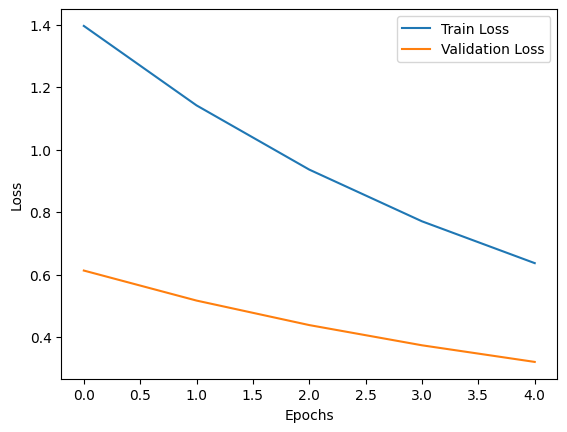

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


y_pred = model.predict(X_val)

# Calculate mean absolute error and mean squared error
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Custom Accuracy Metric based on the acceptable error margin (in years)
def custom_accuracy(y_true, y_pred, tolerance=5):
   
    correct_preds = np.abs(y_true - y_pred) <= tolerance
    accuracy = np.mean(correct_preds)
    return accuracy

tolerance = 5 
accuracy = custom_accuracy(y_val, y_pred, tolerance)
print(f'Custom Accuracy within {tolerance} years: {accuracy * 100:.2f}%')

1/1 [==============================] - 31s 31s/step
Mean Absolute Error: 0.3736594659941537
Mean Squared Error: 0.1432743895886457
Custom Accuracy within 5 years: 100.00%
